# Import Data
The data includes 3D world coordinates, 2D image coordinates, and images of a chessboard box captured from two perspectives.

In [83]:
import cv2
import numpy as np
import scipy.io
from scipy import signal
import scipy
import matplotlib.pyplot as plt

In [84]:
point3D = np.loadtxt('data/Point3D.txt', delimiter=' ')
point2D1 = np.load('1_Point2D.npy')
point2D2 = np.load('2_Point2D.npy')
img1 = cv2.imread('data/chess_1.jpg')
img2 = cv2.imread('data/chess_2.jpg')

In [78]:
import cv2
import numpy as np

# change input image path here
img = cv2.imread('data/S__606377.jpg')

# resize image to 640x480
resized_img = cv2.resize(img, (480, 640))

# change output path here
cv2.imwrite('data/chess_resized.jpg', resized_img)


True

(A) Compute the projection matrix $ {P} $ from a set of 2D-3D point correspondences by using the leastsquares (eigenvector) method for each image.

A pair of corresponding point in homogenous coordinate satisfies:

$$
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\bb}[1]{\mathbf{ #1 }}
\begin{align}
\begin{pmatrix}
u \\ v \\ 1
\end{pmatrix}
&\sim
\bb{P}
\begin{pmatrix}
X \\ Y \\ Z \\ 1
\end{pmatrix}
\end{align}
$$

Where $\sim$ means equality up to scale. We can derive two equations:

$$
\begin{align}
x = \frac
{p_{11} X + p_{12} Y + p_{13} Z + P_{14}}
{p_{31} X + p_{32} Y + p_{33} Z + P_{34}}
,
y = \frac
{p_{21} X + p_{22} Y + p_{23} Z + P_{24}}
{p_{31} X + p_{32} Y + p_{33} Z + P_{34}}
\end{align}
$$

Rearrange it in matrix form:

$$
\begin{pmatrix}
X & Y & Z  & 1 & 0 & 0 & 0 & 0 & -uX & -uY & -uZ & -u \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -vX & -vY & -vZ & -v \\
&&&&&&\vdots\\
&&&&&&\vdots\\
&&&&&&\vdots\\
\end{pmatrix}
\begin{pmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ \vdots \\ p_{34}
\end{pmatrix}
= \bb{0}
$$

It is a homogenious system $\bb{A}\bb{p} = \bb{0}$. Since there are 12 unknows, but the actual degree of freedom of $\bb{p}$ is 11 (5 in $\bb{K}$, 3 in $\bb{R}$, 3 in $\bb{T}$), we add one constraint to the system: $\norm{\bb{p}} = 1$.

Usually more than 6 correspondences are given, the system doesn't have an unique solution. Instead, we try to find the $\bb{p}$ that minimize $\norm{\bb{Ap } - \bb{0}}$. The solution is the eigenvector of $\bb{A^T A}$ which has minimum eigenvalue. The proof is given in Appendix.

Another way to solve this system is to use least square method. However the unit norm constraint cannot be expressed in our system, we use another constraint instead,

$$
p_{11} + p_{12} + \ldots + p_{34} = 1
$$

After adding constraint, the system becomes:

$$
\begin{pmatrix}
X & Y & Z  & 1 & 0 & 0 & 0 & 0 & -xX & -xY & -xZ & -x \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -yX & -yY & -yZ & -y \\
 & & & & & &\vdots\\
 & & & & & &\vdots\\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
\end{pmatrix}
\begin{pmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ \vdots \\ p_{34}
\end{pmatrix} = 
\begin{pmatrix}
0 \\ 0 \\ 0 \\ \vdots \\ 1
\end{pmatrix}
$$

In [73]:
def Projection_Matrix(point2D, point3D):
    ########################################################################
    # TODO:                                                                #
    #   Using 2D coordinator and 3D coordinator,                           #
    #   , calculate the 3D to 2D projection matrix P                       #
    ########################################################################
    lenPoints = len(point3D)
    A = []
    B = []
    M = np.zeros([11,1])
    for n in range(lenPoints):
        x = point3D[n][0]
        y = point3D[n][1]
        z = point3D[n][2]
        u = point2D[n][0]
        v = point2D[n][1]
        A.append([x,y,z,1,0,0,0,0,-u*x,-u*y,-u*z])
        A.append([0,0,0,0,x,y,z,1,-v*x,-v*y,-v*z])
        B.append(u)
        B.append(v)
    M = np.linalg.lstsq(A,B)[0]
    M = np.append(M,1)
    M = M.reshape(3,4)
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    return M

In [85]:
P1 = Projection_Matrix(point2D1, point3D)
P2 = Projection_Matrix(point2D2, point3D)

C:\Users\Steven\AppData\Local\Temp\ipykernel_16236\448338328.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M = np.linalg.lstsq(A,B)[0]


In [103]:
print(P1)
print(P2)

[[ 2.56580908e+01 -2.45281525e+01 -7.39156512e+00  2.08974211e+02]
 [-2.52162769e+00 -6.63541331e+00 -3.28436985e+01  2.69161773e+02]
 [-1.20422549e-02 -7.37634423e-02 -2.27751328e-02  1.00000000e+00]]
[[ 7.80073970e+01 -1.35564846e+01 -3.00627051e+01  1.44420783e+02]
 [-1.78034617e+00  2.83284039e+01 -9.39877951e+01  2.88434923e+02]
 [ 1.83194949e-02 -9.47476366e-02 -1.34017920e-01  1.00000000e+00]]


In [62]:
# Verify the projection matrix (P), use P to project the 3D coordinator to 2D coordinates
# input: P, 3D world coordinator, output: 2D image coordinator
def Verify(P,point3D):
    lenPoints = len(point3D)
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32)
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1

    TwoDD = np.zeros((lenPoints,3),dtype=np.float32)

    for i in range(lenPoints):
        TwoDD[i] = P.dot(ThreeD[i])
        TwoDD[i] = TwoDD[i]/TwoDD[i,-1]
    
    SE = 0.000
    
    for i in range(lenPoints):
        SE = SE + np.square(TwoDD[i,0]-point2D1[i,0])+np.square(TwoDD[i,1]-point2D1[i,1])
    RMSE = np.sqrt(SE/lenPoints)
    
    return RMSE, TwoDD

In [54]:
def Project(img, point2D, TwoD, save_name):
    x = point2D[:,0]
    y = point2D[:,1]
    x1 = TwoD[:,0]
    y1 = TwoD[:,1]
    fig = plt.figure()
    img12 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.plot(x,y,"o", label="original point")
    plt.plot(x1,y1,"x", label="projected point")
    plt.legend(loc='upper right')
    plt.imshow(img12)
    plt.savefig('./output/' + save_name + '.png')

In [86]:
RMSE1, TwoDD1 = Verify(P1,point3D)
RMSE2, TwoDD2 = Verify(P2,point3D)
print(RMSE1, RMSE2)

1.9395367874782508 73.11802920540813


<Figure size 640x480 with 0 Axes>

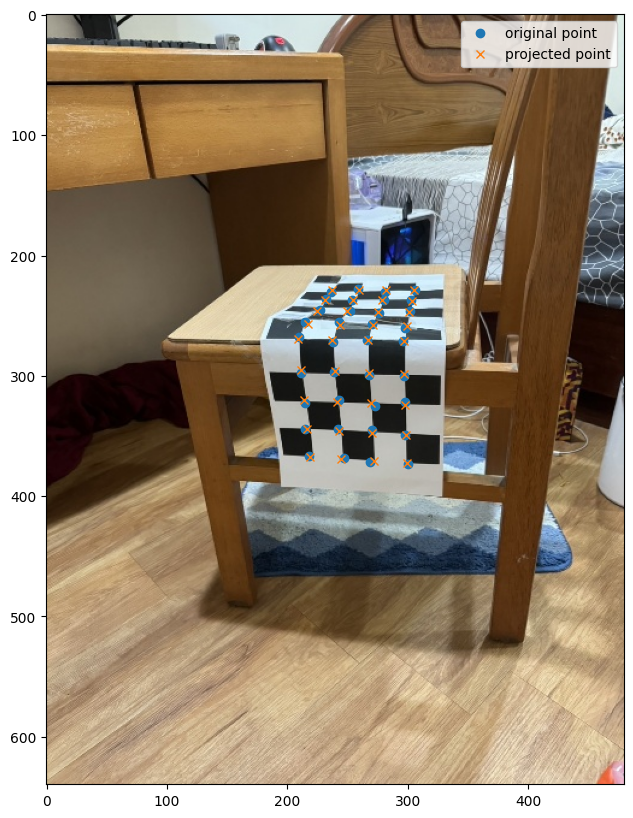

In [87]:
Project(img1, point2D1, TwoDD1,save_name='verify of chessboard_1')

<Figure size 640x480 with 0 Axes>

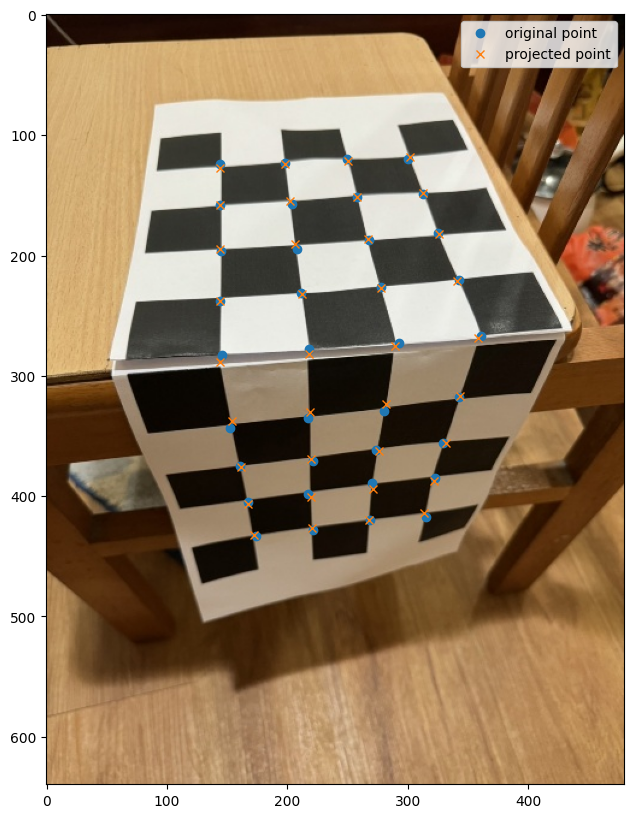

In [88]:
Project(img2, point2D2, TwoDD2,save_name='verify of chessboard_2')

(B) Decompose the two computed projection matrices from (A) into the camera intrinsic matrices K, rotation matrices R and translation vectors t by using the Gram-Schmidt process.

### K, R, T

$$
\begin{align}
\bb{P} 
&= \bb{K} [\bb{R} \mid \bb{T}] = [\bb{KR} \mid \bb{KT}] \\ 
&= [\bb{P_{3\times3}} \mid \bb{P_4}] = [\bb{M} \mid \bb{P_4}]
\end{align}
$$

That is,

$$
\begin{align}
\bb{M} &= \bb{KR} \\
\bb{P_4} &= \bb{KT}
\end{align}
$$
We know $\bb{K}$ is upper triangular, $\bb{R}$ is orthogonal, we can utilize **RQ-decomposition** to find $\bb{K}, \bb{R}$:

$$
\begin{align}
\bb{M} &= \bb{\hat R} \bb{\hat Q} = \bb{KR} \\
\therefore 
\bb{K} &= \bb{\hat R}\\
\bb{R} &= \bb{\hat Q}
\end{align}
$$

We can use **QR-decomposition** in case you are not able to access RQ-decomposition function (like in matlab). Decomposite $\bb{M^{-1}}$ instead, since the inverse of an upper trigular matrix is upper triangular and the inverse of orthogonal maxtrix is also orthogonal:

$$
\begin{align}
\bb{M^{-1}} &= \bb{\dot Q \dot R} \\
\bb{M} &= \bb{(\dot Q \dot R)^{-1}} = \bb{\dot{R}^{-1}\dot{Q}^{-1}} = \bb{KR} \\
\therefore 
\bb{K} &= \bb{\dot{R}^{-1}}\\
\bb{R} &= \bb{\dot{Q}^{-1}}
\end{align}
$$

And $\bb{T}$ is simply:

$$
\bb{T} = \bb{K^{-1} P_4}
$$

In [90]:
def KRt(P):
    ########################################################################
    # TODO:                                                                #
    #   Extract the intrinsic matrix (K), rotation matrix (R)              #
    #   , and translation vector(T) from the projection matrix.            #
    ########################################################################

        M = P[0:3,0:3]
        # QR decomposition
        q, r = np.linalg.qr(np.linalg.inv(M))
        R = np.linalg.inv(q)
        K = np.linalg.inv(r)
        # translation vector
        t = np.dot(np.linalg.inv(K),P[:,-1])
        
        D = np.array([[np.sign(K[0,0]),0,0],
                [0,np.sign(K[1,1]),0],
                [0,0,np.sign(K[2,2])]])
        
        # K,R,t correction
        K = np.dot(K, D)
        R = np.dot(np.linalg.inv(D), R)
        t = np.dot(np.linalg.inv(D), t)    
        t = np.expand_dims(t,axis=1)
        
        # normalize K
        K = K / K[-1,-1]


    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    #####################z###################################################
        return K, R, t

In [91]:
K1, R1, T1 = KRt(P1)
K2, R2, T2 = KRt(P2)

In [102]:
print(K1)
print(K2)

[[374.99661026  -2.48926072 273.33447687]
 [  0.         376.59293789 207.67973564]
 [  0.           0.           1.        ]]
[[449.17433557 -10.86779663 247.21568121]
 [  0.         471.40244652 362.23354857]
 [  0.           0.           1.        ]]


In [92]:
np.savetxt("./output/intrinsic matrices of chessboard_1.txt",K1)
np.savetxt("./output/rotation matrices of chessboard_1.txt",R1)
np.savetxt("./output/translation vectors of chessboard_1.txt",T1)
np.savetxt("./output/intrinsic matrices of chessboard_2.txt",K2)
np.savetxt("./output/rotation matrices of chessboard_2.txt",R2)
np.savetxt("./output/translation vectors of chessboard_2.txt",T2)

(C) Re-project 2D points on each of the chessboard images by using the computed intrinsic matrix, rotation matrix and translation vector. Show the results (2 images) and compute the point reprojection root-mean-squared errors. 

In [93]:
def ReProject2D(K, R, T, point2D, point3D):
    lenPoints = len(point3D)
    Pro = np.zeros((3,4),dtype=np.float32)
    Pro[0,0] = 1
    Pro[1,1] = 1
    Pro[2,2] = 1
    Rt = np.zeros((4,4),dtype=np.float32)
    for i in range(3):
        for j in range(3):
            Rt[i,j]=R[i,j]
    Rt[0,3]=T[0]
    Rt[1,3]=T[1]
    Rt[2,3]=T[2]
    Rt[3,3] = 1
    KPRt = K.dot(Pro).dot(Rt)
    
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32)
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1
    
    TwoD = np.zeros((lenPoints,3),dtype=np.float32)
    for i in range(lenPoints):
        TwoD[i] = KPRt.dot(ThreeD[i])
        TwoD[i] = TwoD[i]/TwoD[i,-1]
    
    SE = 0.000
    for i in range(lenPoints):
        SE = SE + np.square(TwoD[i,0]-point2D[i,0])+np.square(TwoD[i,1]-point2D[i,1])
    
    RMSE = np.sqrt(SE/lenPoints)
    
    SEX = 0.000
    for i in range(lenPoints):
        SEX = SEX + np.square(TwoD[i,0]-point2D[i,0])
    
    SEY = 0.000
    for i in range(lenPoints):
        SEY = SEY + np.square(TwoD[i,1]-point2D[i,1])    
        
    return RMSE, TwoD, SEX, SEY

In [94]:
RMSE1, TwoD1, SE_X1, SE_Y1 = ReProject2D(K1, R1, T1, point2D1, point3D)
RMSE2, TwoD2, SE_X2, SE_Y2 = ReProject2D(K2, R2, T2, point2D2, point3D)

In [95]:
print("RMSE of 1st image: ",RMSE1)
print("RMSE of 2nd image: ",RMSE2)

RMSE of 1st image:  1.9395350518180037
RMSE of 2nd image:  2.9889640167926554


<Figure size 640x480 with 0 Axes>

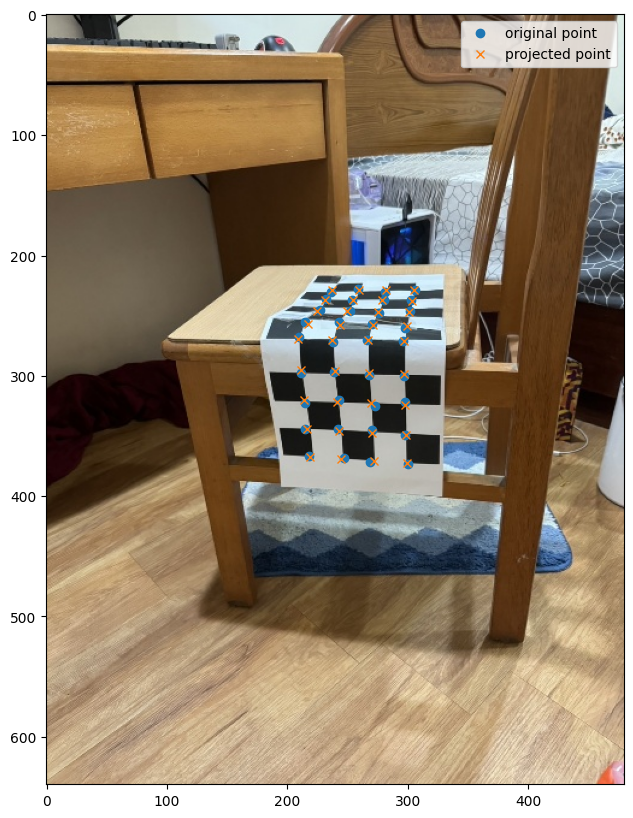

In [97]:
Project(img1, point2D1, TwoD1,save_name='ReProject2D of chessboard_1')

<Figure size 640x480 with 0 Axes>

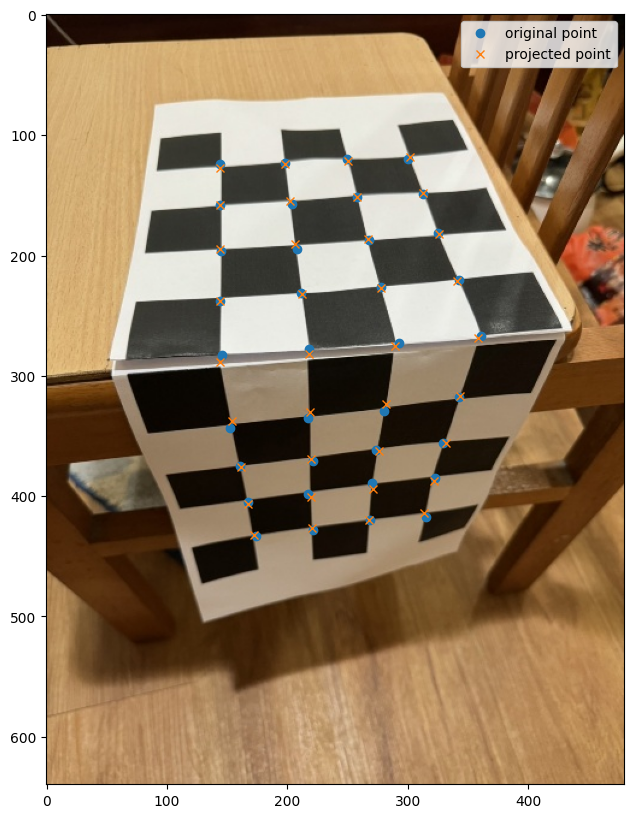

In [98]:
Project(img2, point2D2, TwoD2,save_name='ReProject2D of chessboard_2')

(D) Plot camera poses for the computed extrinsic parameters (R, t) and then compute the angle between the two camera pose vectors.

In [99]:
from visualize import visualize
# Input:
# pts: 36x3 3D points
# R1: 3x3 rotation matrix of image 1
# T1: 3x1 translation vector of image 1
# R2: 3x3 roatation matrix of image 2
# T2: 3x1 translation vector of image 2

In [100]:
T11 = T1.reshape(3,1)
T22 = T2.reshape(3,1)

Angle between two cameras:  40.44024732178755


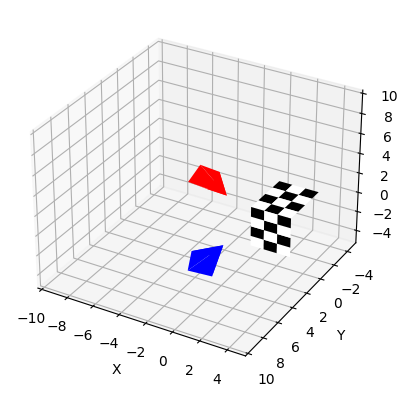

In [101]:
save_name='3D'
visualize(point3D, R1, T1.reshape(3,1), R2, T2.reshape(3,1),save_name)

(E) Print out two “chessboard.png” in the attached file and paste them on a box. Take two pictures from different angles. For each image, perform the steps above (A ~ D).

(F) Instead of mark the 2D points by hand, you can find the 2D points in your images automatically by using corner detection, hough transform, etc.